In [2]:
%matplotlib inline

# Built-in
import csv
import os
import re

# Scientific/ML libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
shap.initjs()

# IPython display
from IPython.display import Markdown, display

# Scipy
from scipy.stats import chi2_contingency

# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# AIF360 fairness library
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


# Seed for reproducibility
np.random.seed(1)


C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# Load Base Cleaned/Encoded Data

In [3]:
df = pd.concat([pd.read_csv('dataset/train_test_extracted_overunder/train.csv'), pd.read_csv('dataset/train_test_extracted_overunder/val.csv')])
df.head

<bound method NDFrame.head of        race  gender  age  admission_type_id  discharge_disposition_id  \
0         3       0   45                  1                         1   
1         3       0   85                  3                         1   
2         3       0   65                  6                        25   
3         3       0   25                  1                         6   
4         3       0   55                  1                         1   
...     ...     ...  ...                ...                       ...   
10144     3       0   75                  3                         1   
10145     3       0   65                  1                         1   
10146     3       0   85                  6                        25   
10147     3       1   85                  3                         1   
10148     1       1   75                  1                        18   

       admission_source_id  time_in_hospital  medical_specialty  \
0                        7

# Correlation Visualization

In [4]:
numeric_columns = df.columns
correlation_matrix = df[numeric_columns].corr()
print(correlation_matrix)

                              race    gender       age  admission_type_id  \
race                      1.000000  0.009246  0.079357           0.087225   
gender                    0.009246  1.000000 -0.048671          -0.001965   
age                       0.079357 -0.048671  1.000000          -0.024930   
admission_type_id         0.087225 -0.001965 -0.024930           1.000000   
discharge_disposition_id  0.028346 -0.028237  0.091780           0.042710   
...                            ...       ...       ...                ...   
diag_3_Injury             0.012553  0.040518  0.006227           0.004795   
diag_3_Muscoloskeletal    0.003919 -0.027624 -0.001313           0.022197   
diag_3_Neoplasms          0.000407  0.045206  0.047670          -0.004143   
diag_3_Other              0.014980 -0.030259 -0.131652          -0.019745   
diag_3_Respiratory        0.013774  0.004305  0.054552          -0.019956   

                          discharge_disposition_id  admission_source_id  \


In [5]:
# Correlation with readmitted patients
correlation_with_readmitted = df.corr()['readmitted']
sorted_correlation_readmitted = correlation_with_readmitted.abs().sort_values(ascending=False)
sorted_correlation_readmitted = sorted_correlation_readmitted[1:]
print(sorted_correlation_readmitted)

race_Caucasian                       0.233239
number_inpatient                     0.193371
race_Asian                           0.128879
race_Other                           0.120365
race_Hispanic                        0.116648
                                       ...   
glipizide_metformin_medicine         0.000440
acetohexamide_medicine                    NaN
troglitazone_medicine                     NaN
glimepiride_pioglitazone_medicine         NaN
metformin_pioglitazone_medicine           NaN
Name: readmitted, Length: 71, dtype: float64


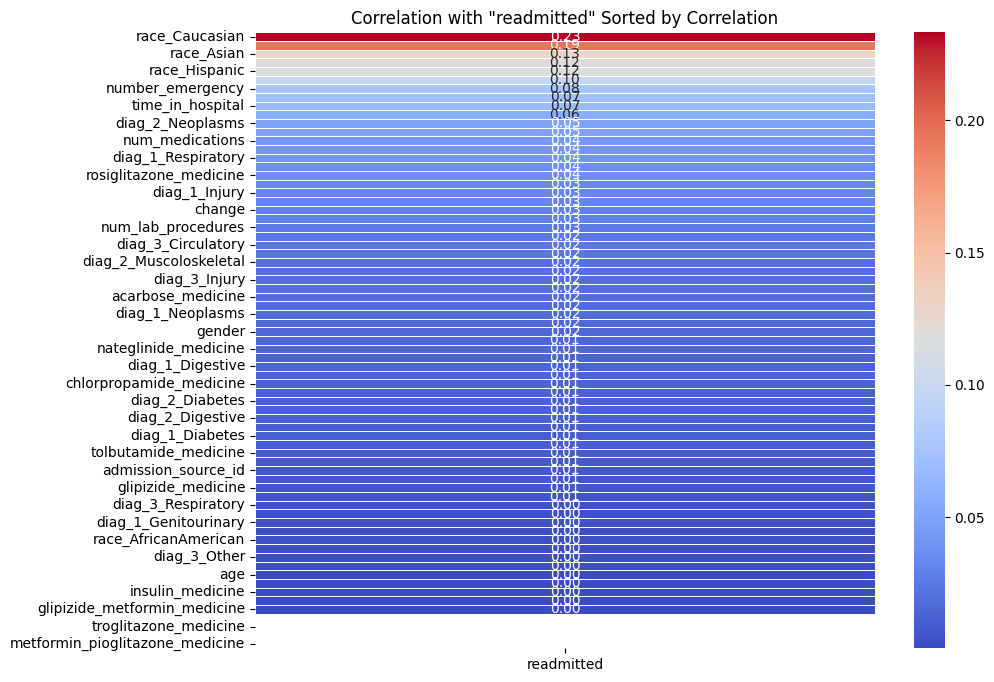

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_readmitted.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "readmitted" Sorted by Correlation')
plt.show()

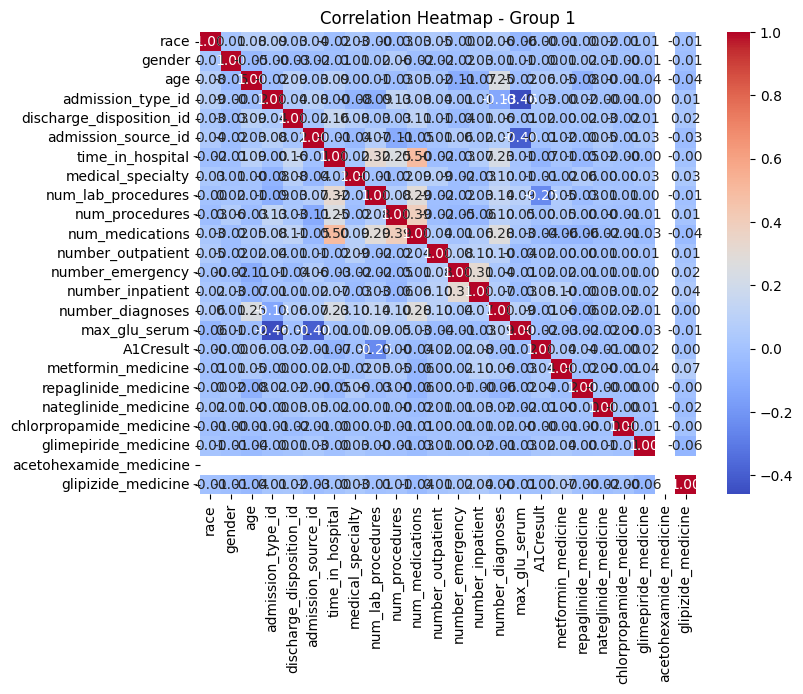

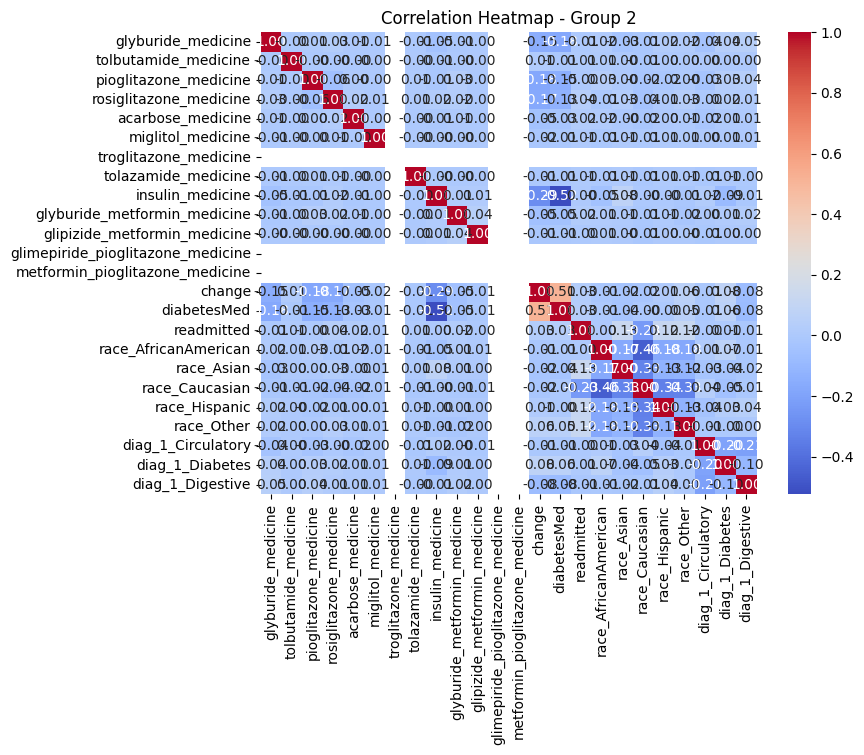

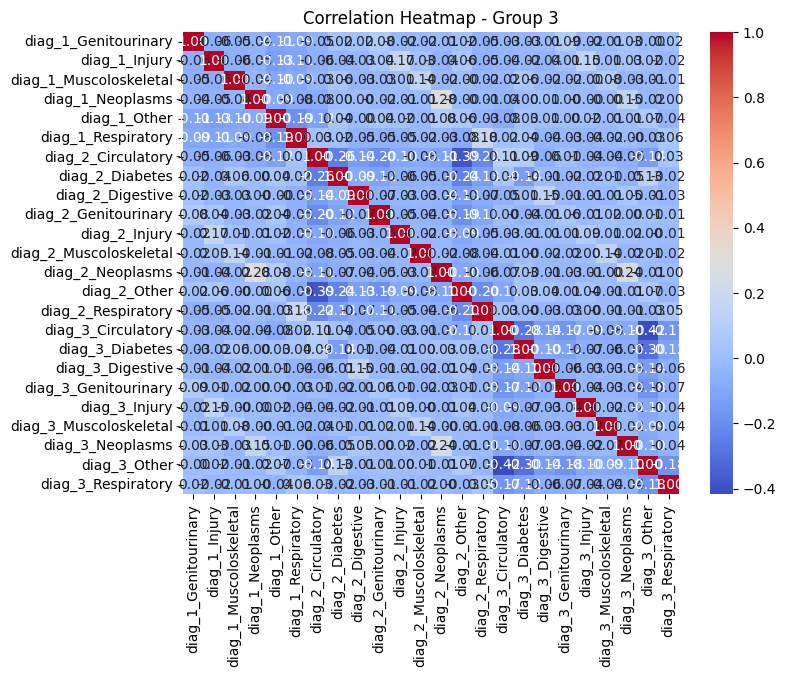

In [7]:
# Heatmap Visualization
num_columns = len(correlation_with_readmitted)
group_size = num_columns // 3  # number of columns per group

# split the columns into three groups for better visibility
group_1 = correlation_with_readmitted[:group_size].index  # first group
group_2 = correlation_with_readmitted[group_size:2*group_size].index  # second group
group_3 = correlation_with_readmitted[2*group_size:].index  # third group

group_1_matrix = df[group_1].corr()
group_2_matrix = df[group_2].corr()
group_3_matrix = df[group_3].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(group_1_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 1")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_2_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 2")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_3_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 3")
plt.show()

In [8]:
# # Correlation with age
# correlation_with_age = df.corr()['age']
# sorted_correlation_age = correlation_with_age.abs().sort_values(ascending=False)
# sorted_correlation_age = sorted_correlation_age[1:]
# print(sorted_correlation_age)

In [9]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(sorted_correlation_age.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation with "age" Sorted by Correlation')
# plt.show()

In [10]:
# Correlation with race
correlation_with_race = df.corr()['race']
sorted_correlation_race = correlation_with_race.abs().sort_values(ascending=False)
sorted_correlation_race = sorted_correlation_race[1:]
print(sorted_correlation_race)

race_Other                           0.660869
race_Caucasian                       0.553222
race_AfricanAmerican                 0.517054
race_Hispanic                        0.508632
readmitted                           0.097109
                                       ...   
miglitol_medicine                    0.000370
acetohexamide_medicine                    NaN
troglitazone_medicine                     NaN
glimepiride_pioglitazone_medicine         NaN
metformin_pioglitazone_medicine           NaN
Name: race, Length: 71, dtype: float64


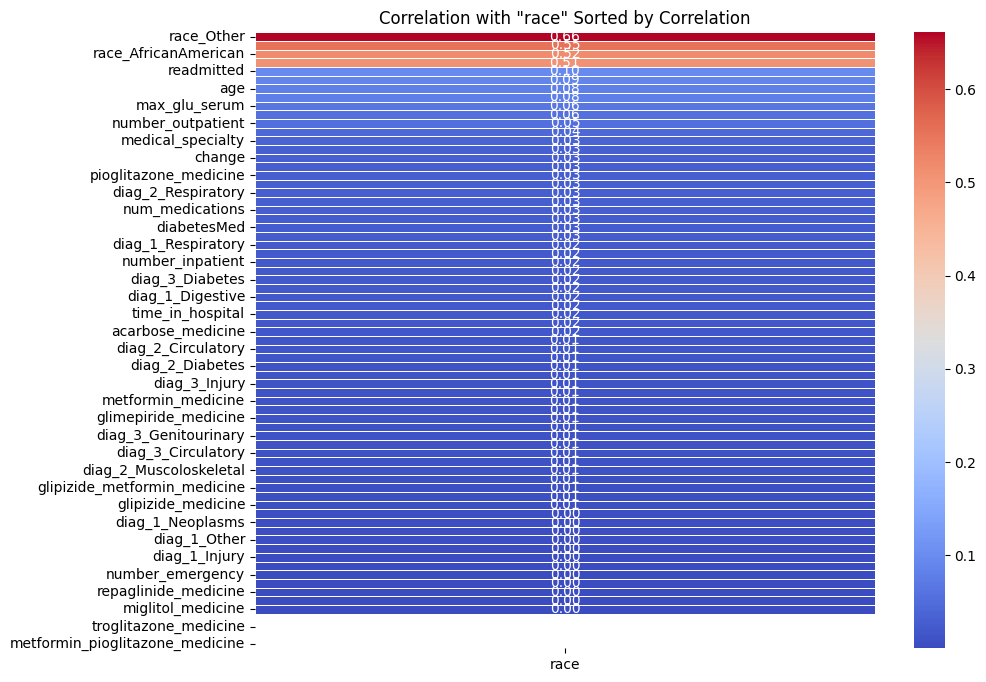

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_race.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "race" Sorted by Correlation')
plt.show()

In [12]:
# Correlation with gender
correlation_with_gender = df.corr()['gender']
sorted_correlation_gender = correlation_with_gender.abs().sort_values(ascending=False)
sorted_correlation_gender = sorted_correlation_gender[1:]
print(sorted_correlation_gender)

num_procedures                       0.064491
age                                  0.048671
diag_3_Neoplasms                     0.045206
diag_1_Circulatory                   0.043314
diag_1_Genitourinary                 0.042215
                                       ...   
tolbutamide_medicine                 0.000456
acetohexamide_medicine                    NaN
troglitazone_medicine                     NaN
glimepiride_pioglitazone_medicine         NaN
metformin_pioglitazone_medicine           NaN
Name: gender, Length: 71, dtype: float64


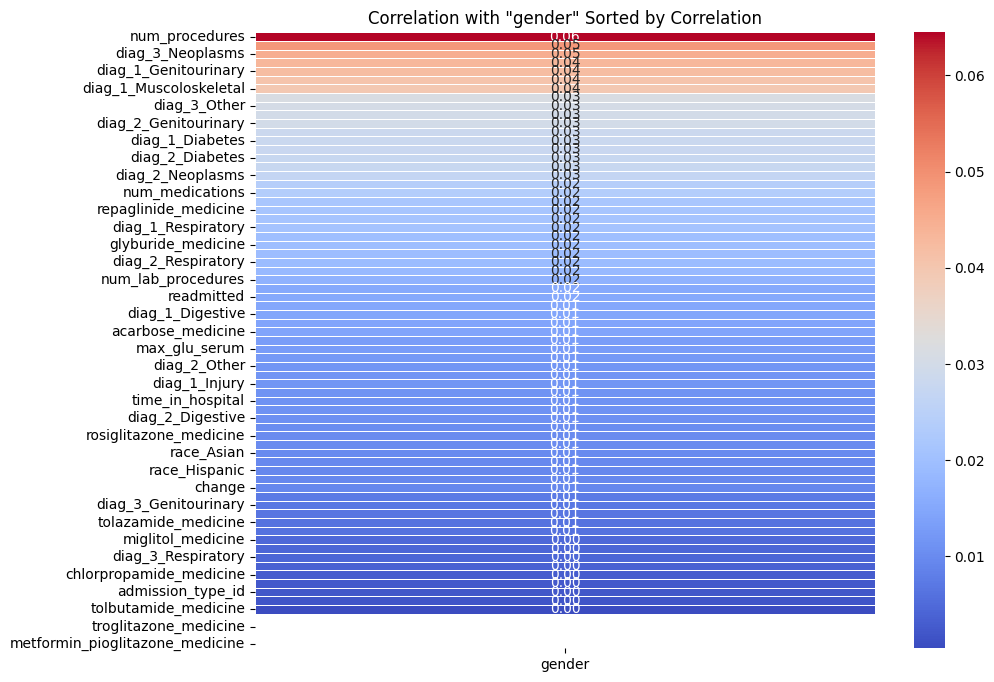

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_gender.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "gender" Sorted by Correlation')
plt.show()

# important Feature Extraction with RF and GBM

In [14]:
# helper function for model evaluation

def evaluate_model_and_features(
    X, 
    y, 
    model, 
    feature_names=None, 
    top=20, 
    title="Model", 
    multi_output=False,
    average='binary'
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if multi_output:
        model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    rec = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f"\n--- {title} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if multi_output:
        importances = np.mean(
            [est.feature_importances_ for est in model.estimators_], axis=0
        )
    else:
        importances = model.feature_importances_

    if feature_names is None:
        feature_names = np.arange(len(importances))
    else:
        feature_names = np.array(feature_names)

    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    print(f"\nTop {top} Features by Importance:")
    for i in range(min(top, len(sorted_features))):
        print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features[:top], sorted_importances[:top], color="royalblue")
    plt.xlabel("Feature Importance Score")
    plt.title(f"Top {top} Feature Importances - {title}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_feature_data = X.loc[:, sorted_features[:top]]
    corr_matrix = top_feature_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap of Top {top} Features - {title}")
    plt.tight_layout()
    plt.show()

    return list(sorted_features[:top])



--- Random Forest - Readmitted ---
Accuracy : 0.8401
Precision: 0.8401
Recall   : 0.8401
F1 Score : 0.8401

Top 30 Features by Importance:
1. num_lab_procedures (0.0791)
2. num_medications (0.0709)
3. time_in_hospital (0.0549)
4. number_inpatient (0.0518)
5. age (0.0452)
6. discharge_disposition_id (0.0420)
7. medical_specialty (0.0407)
8. number_diagnoses (0.0387)
9. num_procedures (0.0369)
10. insulin_medicine (0.0282)
11. admission_type_id (0.0273)
12. race (0.0252)
13. race_Caucasian (0.0232)
14. admission_source_id (0.0217)
15. gender (0.0178)
16. A1Cresult (0.0173)
17. number_outpatient (0.0172)
18. number_emergency (0.0169)
19. diag_3_Other (0.0144)
20. change (0.0140)
21. diag_3_Circulatory (0.0140)
22. diag_1_Circulatory (0.0136)
23. diag_2_Circulatory (0.0134)
24. diag_2_Other (0.0131)
25. metformin_medicine (0.0126)
26. glipizide_medicine (0.0126)
27. diag_1_Other (0.0119)
28. race_Asian (0.0115)
29. diag_3_Diabetes (0.0106)
30. glyburide_medicine (0.0103)


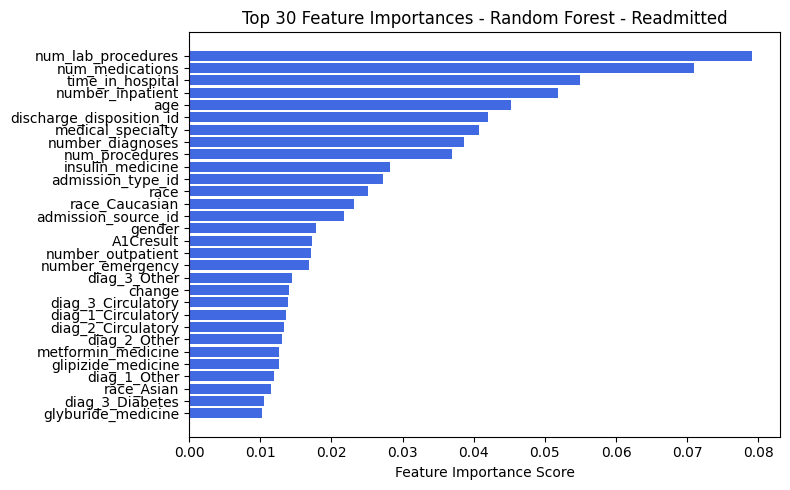

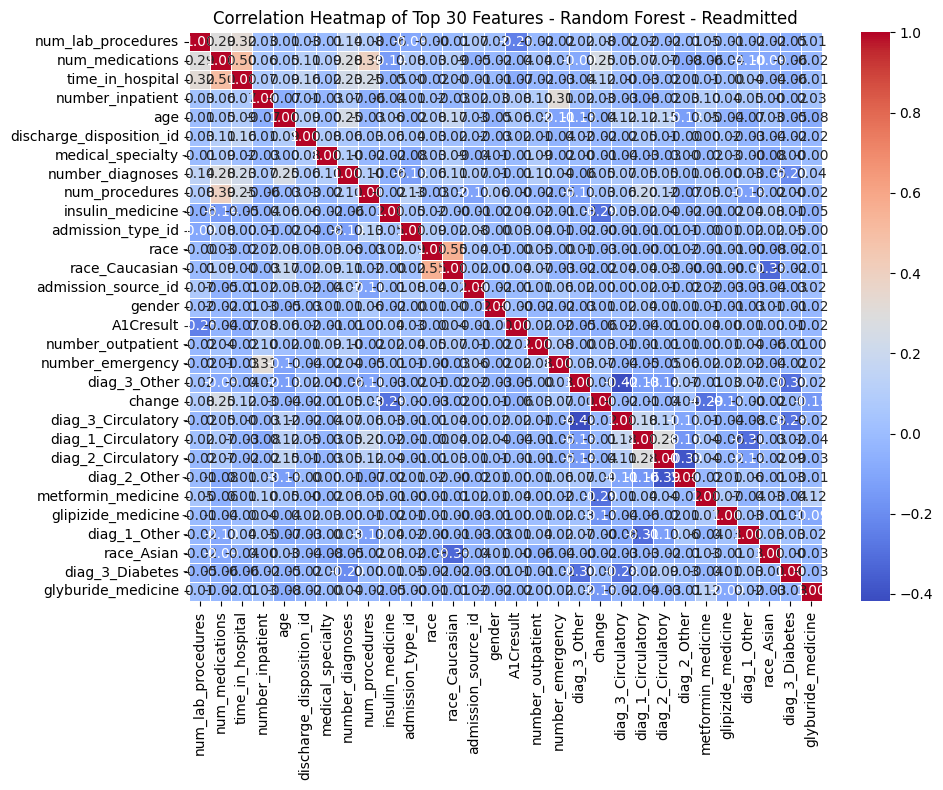

In [15]:
X_readmitted = df.drop(['readmitted'], axis=1)
y_readmitted = df['readmitted']

rf_readmitted = RandomForestClassifier(random_state=42)

top20_features_readmitted = evaluate_model_and_features(
    X_readmitted,
    y_readmitted,
    model=rf_readmitted,
    feature_names=X_readmitted.columns,
    top=30,
    title="Random Forest - Readmitted",
    average='micro'
)



--- Random Forest - Gender ---
Accuracy : 0.6798
Precision: 0.6838
Recall   : 0.6079
F1 Score : 0.6436

Top 20 Features by Importance:
1. num_lab_procedures (0.0882)
2. num_medications (0.0769)
3. time_in_hospital (0.0579)
4. age (0.0525)
5. medical_specialty (0.0439)
6. number_diagnoses (0.0408)
7. num_procedures (0.0371)
8. discharge_disposition_id (0.0326)
9. number_inpatient (0.0318)
10. insulin_medicine (0.0289)
11. admission_type_id (0.0288)
12. race (0.0247)
13. admission_source_id (0.0239)
14. A1Cresult (0.0195)
15. number_outpatient (0.0190)
16. readmitted (0.0182)
17. change (0.0153)
18. number_emergency (0.0147)
19. diag_2_Circulatory (0.0143)
20. diag_3_Other (0.0140)


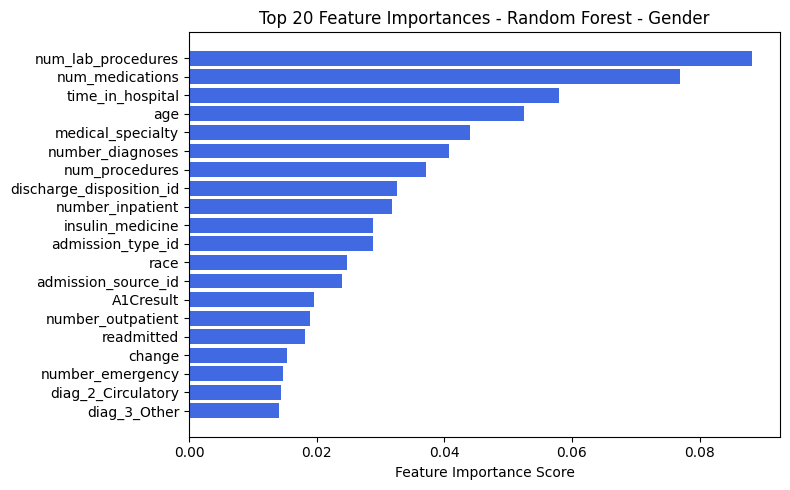

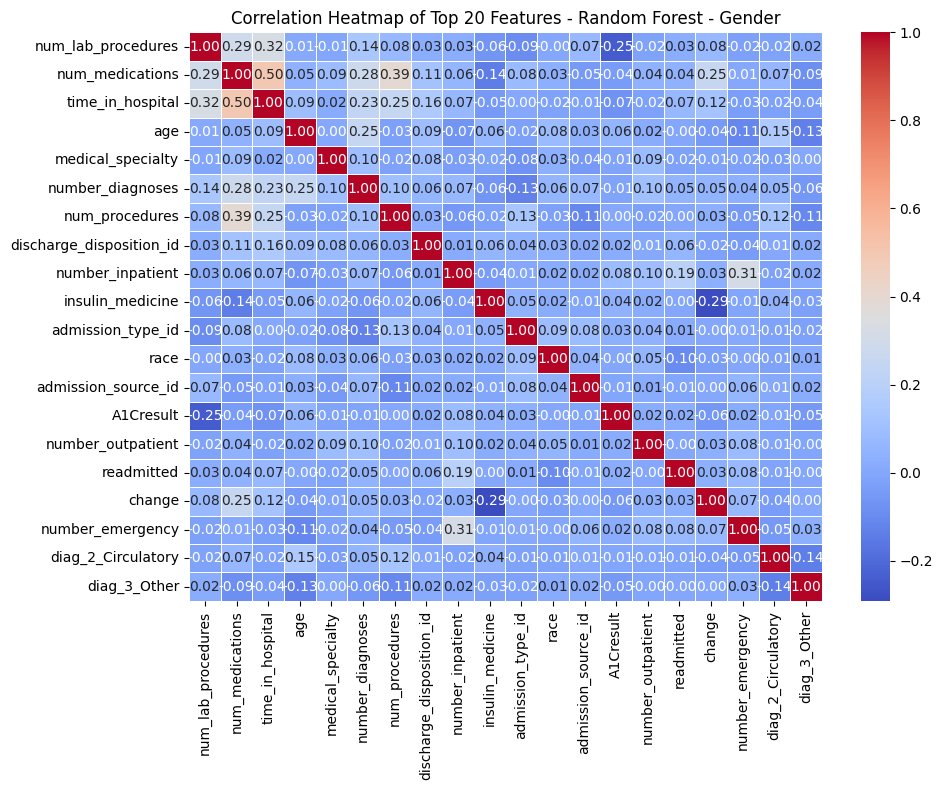

In [16]:
X_gender = df.drop(['gender'], axis=1)
y_gender = df['gender']

rfg = RandomForestClassifier(random_state=42)
top20_features_gender = evaluate_model_and_features(
    X_gender, 
    y_gender, 
    model=rfg, 
    feature_names=X_gender.columns, 
    top=20, 
    title="Random Forest - Gender", 
    multi_output=False,
    average='binary'
)


In [17]:
# X_age = df.drop(['age', 'readmitted'], axis=1)
# y_age = df['age']

# gbm_age = GradientBoostingClassifier(
#     n_estimators=100, 
#     learning_rate=0.1, 
#     max_depth=3, 
#     random_state=42
# )

# top20_features_age = evaluate_model_and_features(
#     X_age, 
#     y_age, 
#     model=gbm_age, 
#     feature_names=X_age.columns,
#     top=20,
#     title="GBM - Age",
#     multi_output=False,
#     average='micro'
# )



--- GBM - Race Labeling (Multi-class) ---
Accuracy : 0.5479
Precision: 0.5479
Recall   : 0.5479
F1 Score : 0.5479

Top 20 Features by Importance:
1. age (0.1261)
2. medical_specialty (0.0994)
3. num_lab_procedures (0.0912)
4. admission_type_id (0.0702)
5. num_medications (0.0702)
6. admission_source_id (0.0533)
7. discharge_disposition_id (0.0442)
8. insulin_medicine (0.0397)
9. number_diagnoses (0.0371)
10. time_in_hospital (0.0353)
11. number_outpatient (0.0322)
12. number_inpatient (0.0285)
13. number_emergency (0.0263)
14. num_procedures (0.0233)
15. diag_3_Neoplasms (0.0151)
16. A1Cresult (0.0108)
17. metformin_medicine (0.0105)
18. max_glu_serum (0.0098)
19. glipizide_medicine (0.0094)
20. diag_1_Injury (0.0091)


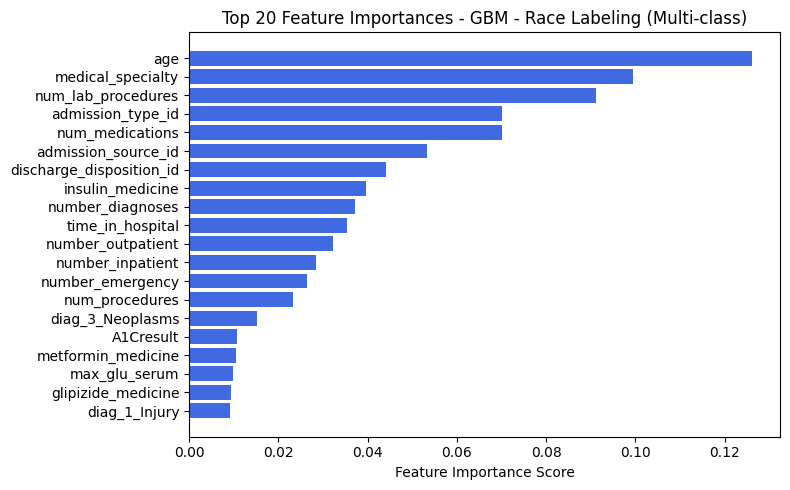

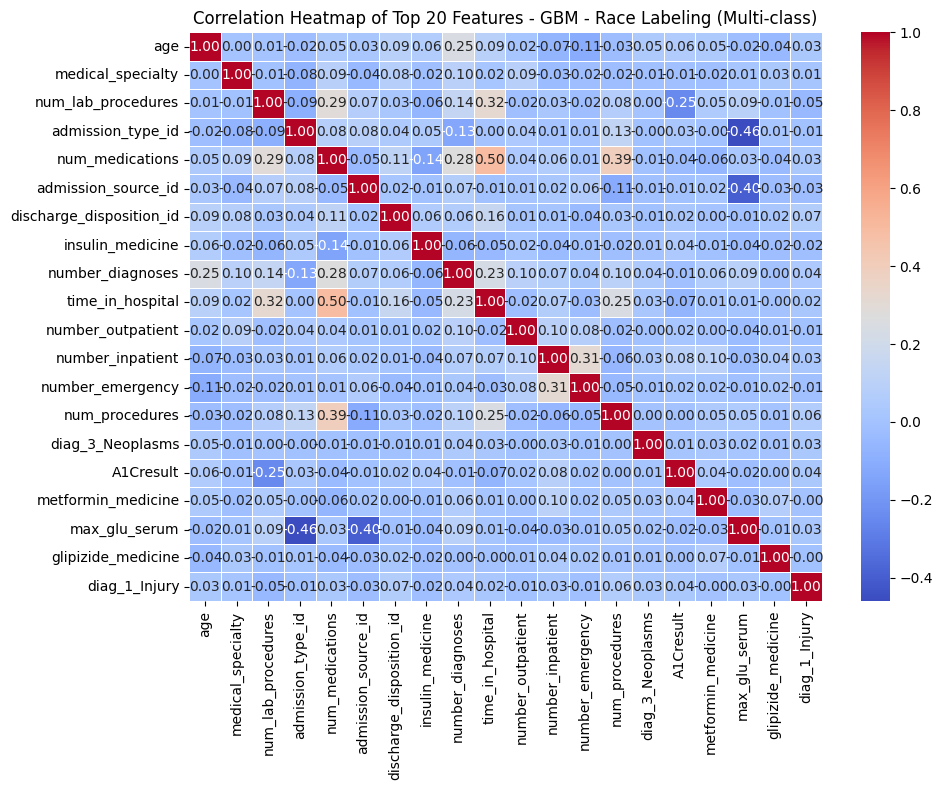

In [18]:
X_race_labeling = df.drop(
    [
        'race',
        'readmitted',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
    ],
    axis=1
)
y_race_labeling = df['race']

gbr1 = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_labeling = evaluate_model_and_features(
    X_race_labeling,
    y_race_labeling,
    model=gbr1,
    feature_names=X_race_labeling.columns,
    top=20,
    title="GBM - Race Labeling (Multi-class)",
    multi_output=False,
    average='micro'
)



--- GBM - Race (Multi-Output Binary) ---
Accuracy : 0.3097
Precision: 0.7010
Recall   : 0.3130
F1 Score : 0.4328

Top 20 Features by Importance:
1. age (0.1127)
2. medical_specialty (0.0998)
3. num_lab_procedures (0.0963)
4. admission_type_id (0.0793)
5. num_medications (0.0647)
6. discharge_disposition_id (0.0434)
7. admission_source_id (0.0404)
8. time_in_hospital (0.0386)
9. insulin_medicine (0.0348)
10. number_diagnoses (0.0340)
11. number_inpatient (0.0336)
12. number_emergency (0.0334)
13. number_outpatient (0.0285)
14. num_procedures (0.0261)
15. diag_3_Neoplasms (0.0147)
16. max_glu_serum (0.0122)
17. A1Cresult (0.0118)
18. diag_2_Circulatory (0.0098)
19. metformin_medicine (0.0096)
20. diag_1_Injury (0.0090)


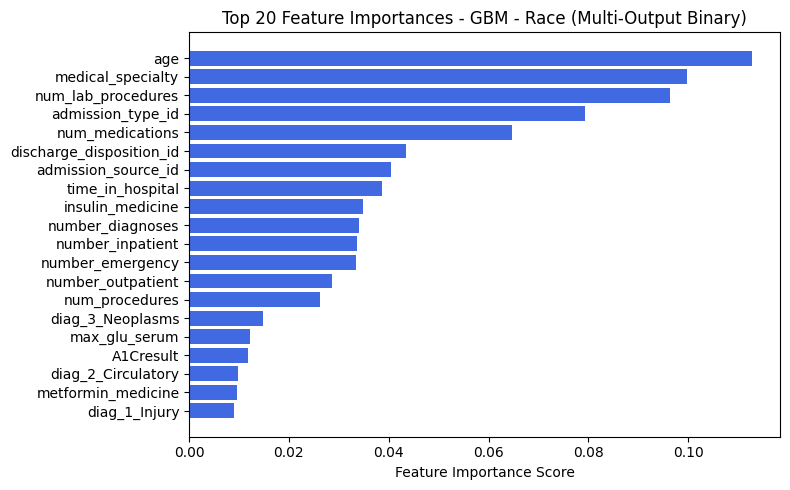

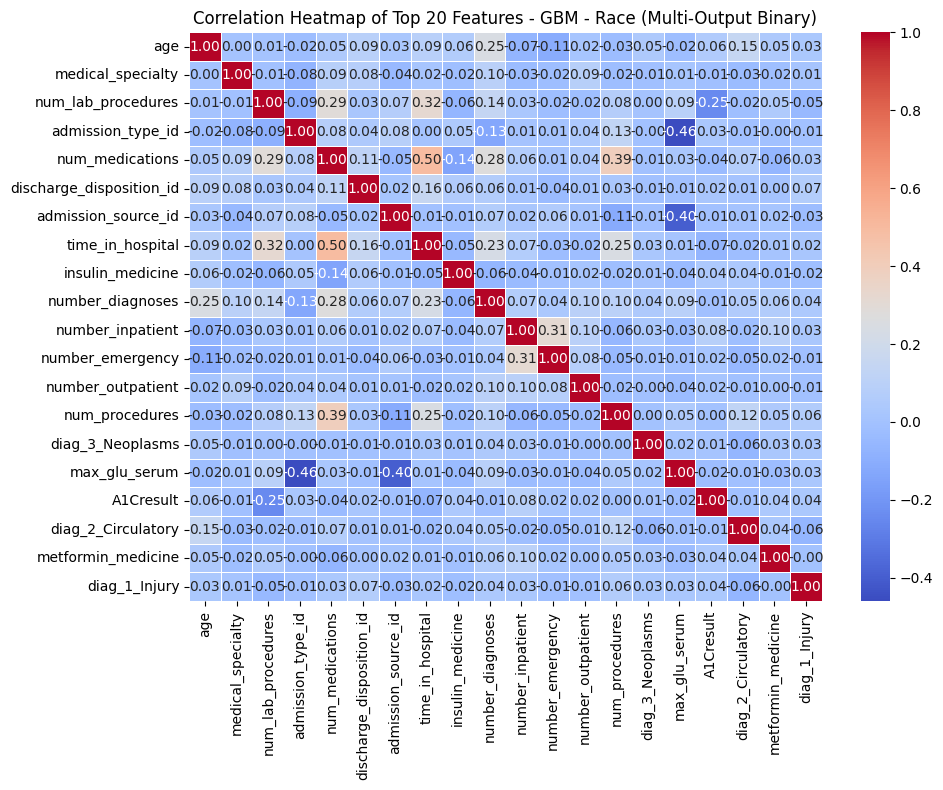

In [19]:
# 2) Multi-output (separate binary columns)
X_race_multi = df.drop(
    [
        'race',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
        'readmitted' 
    ], 
    axis=1
)

y_race_multi = df[[
    'race_AfricanAmerican',
    'race_Asian',
    'race_Caucasian',
    'race_Hispanic',
    'race_Other'
]]

gbr_multi = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_multi = evaluate_model_and_features(
    X_race_multi,
    y_race_multi,
    model=gbr_multi,
    feature_names=X_race_multi.columns,
    top=20,
    title="GBM - Race (Multi-Output Binary)",
    multi_output=True,
    average='micro'
)


## Extract most important feature in classifying readmitted, and demographics

In [20]:
all_features_related_to_demographics_readmitted = set(top20_features_race_labeling) | set(top20_features_race_multi) | set(top20_features_gender) | set(top20_features_readmitted)


columns_to_remove = {
    'readmitted', 'age', 'gender', 'race', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other', 'medical_specialty', 'admission_type_id', 'admission_source_id'
}

all_features_related_to_demographics_readmitted = all_features_related_to_demographics_readmitted - columns_to_remove
top20_features_readmitted = set(top20_features_readmitted) - columns_to_remove

print("Number of combined features:", len(top20_features_readmitted))
print(top20_features_readmitted)


Number of combined features: 22
{'metformin_medicine', 'glipizide_medicine', 'discharge_disposition_id', 'diag_1_Circulatory', 'number_inpatient', 'num_procedures', 'num_medications', 'number_emergency', 'diag_3_Diabetes', 'A1Cresult', 'diag_2_Other', 'time_in_hospital', 'diag_1_Other', 'num_lab_procedures', 'insulin_medicine', 'number_diagnoses', 'number_outpatient', 'change', 'diag_3_Circulatory', 'glyburide_medicine', 'diag_3_Other', 'diag_2_Circulatory'}


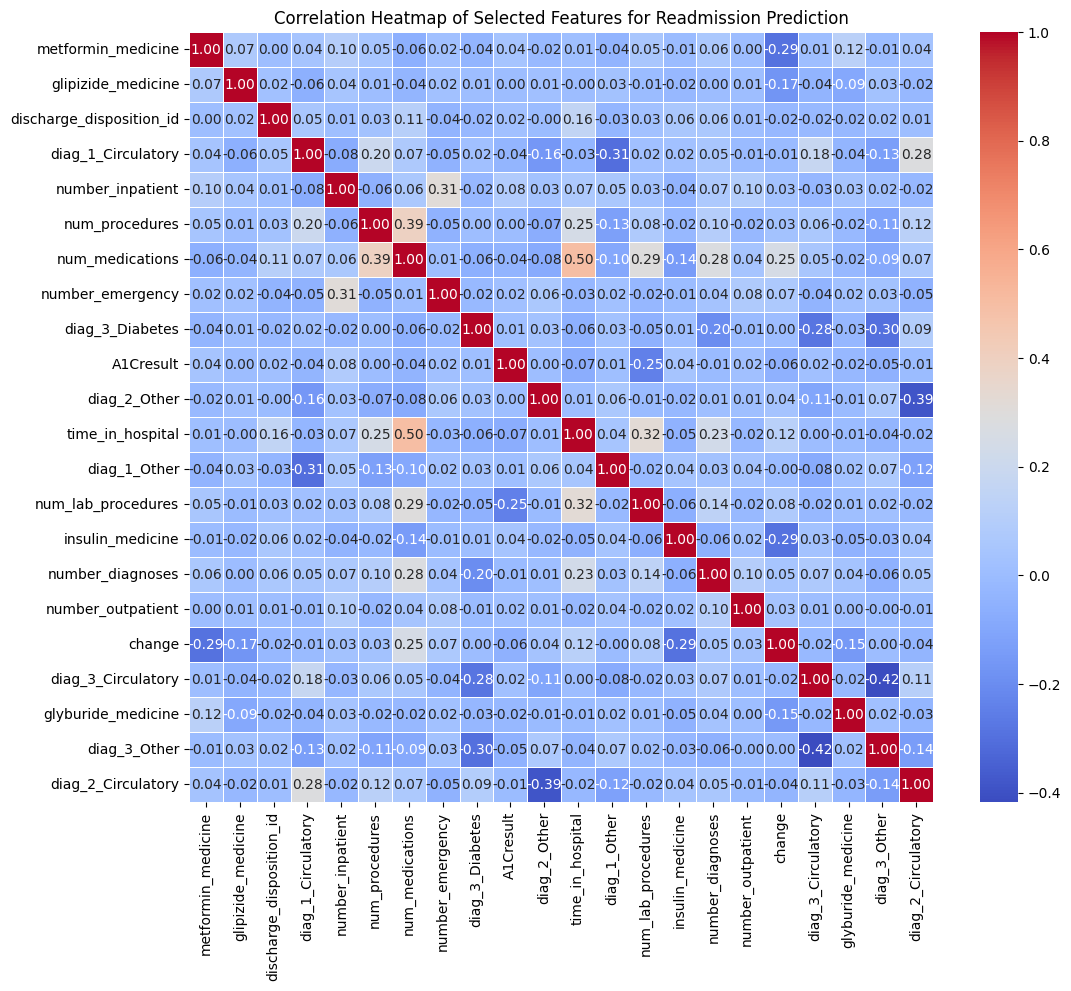

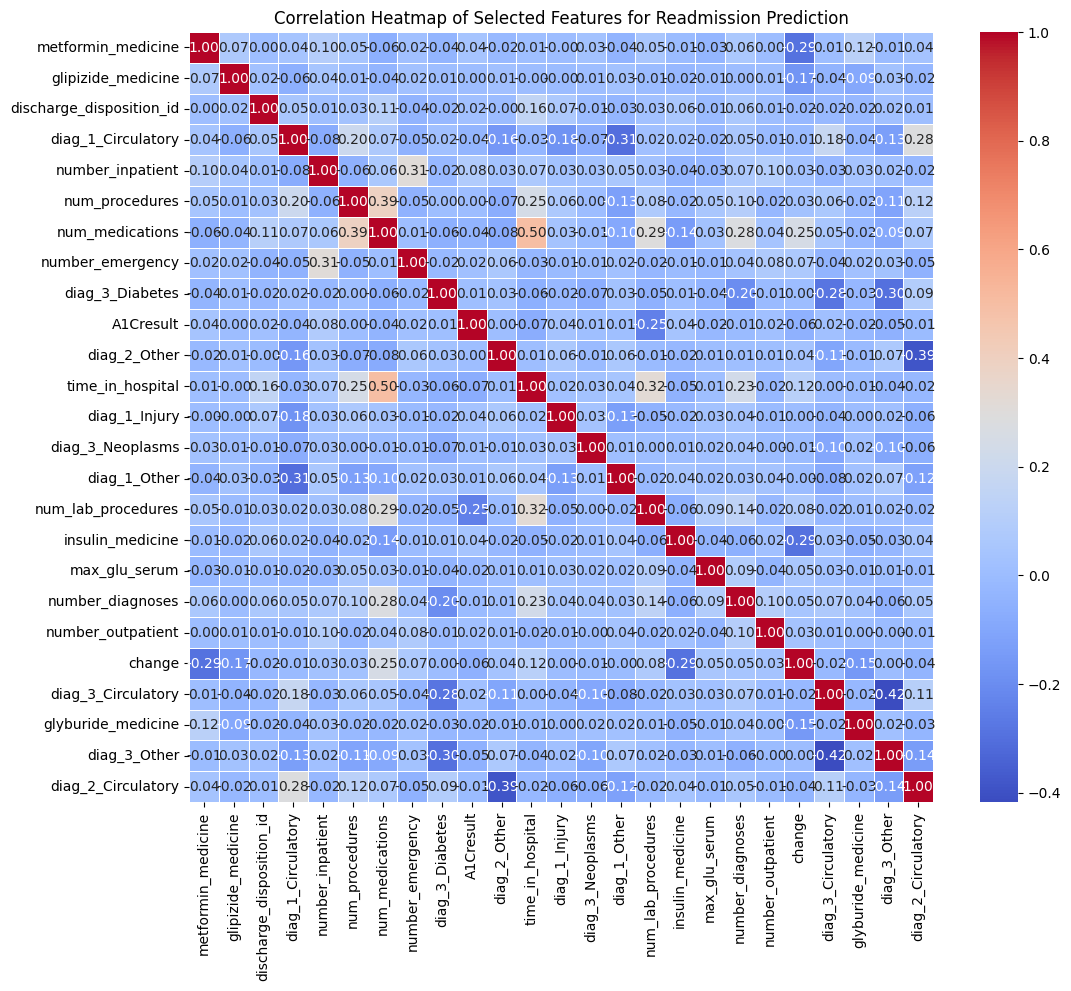

In [21]:
selected_columns_cherry_picked = df[list(top20_features_readmitted)]
selected_columns_all_demographics = df[list(all_features_related_to_demographics_readmitted)]

correlation_matrix_cherry_picked = selected_columns_cherry_picked.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_cherry_picked, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

correlation_matrix_all = selected_columns_all_demographics.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

In [22]:
#create a list of columns including columns with high importance, readmitted, and missed demographics
selected_columns_cherry_picked = list(selected_columns_cherry_picked) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_cherry_picked)

selected_columns_all_demographics = list(selected_columns_all_demographics) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_all_demographics)

['metformin_medicine', 'glipizide_medicine', 'discharge_disposition_id', 'diag_1_Circulatory', 'number_inpatient', 'num_procedures', 'num_medications', 'number_emergency', 'diag_3_Diabetes', 'A1Cresult', 'diag_2_Other', 'time_in_hospital', 'diag_1_Other', 'num_lab_procedures', 'insulin_medicine', 'number_diagnoses', 'number_outpatient', 'change', 'diag_3_Circulatory', 'glyburide_medicine', 'diag_3_Other', 'diag_2_Circulatory', 'readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
['metformin_medicine', 'glipizide_medicine', 'discharge_disposition_id', 'diag_1_Circulatory', 'number_inpatient', 'num_procedures', 'num_medications', 'number_emergency', 'diag_3_Diabetes', 'A1Cresult', 'diag_2_Other', 'time_in_hospital', 'diag_1_Injury', 'diag_3_Neoplasms', 'diag_1_Other', 'num_lab_procedures', 'insulin_medicine', 'max_glu_serum', 'number_diagnoses', 'number_outpatient', 'change', 'diag_3_Circulatory', 'glyburide_medicine', 'di

In [23]:
df_extracted_features_cherry_picked = df[selected_columns_cherry_picked]

df_extracted_features_cherry_picked.columns = [col.replace("-", "_") for col in df_extracted_features_cherry_picked.columns]

df_extracted_features_cherry_picked.head()
df_extracted_features_cherry_picked.info()

selected_columns_all_demographics = df[selected_columns_all_demographics]

selected_columns_all_demographics.columns = [col.replace("-", "_") for col in selected_columns_all_demographics.columns]


<class 'pandas.core.frame.DataFrame'>
Index: 21389 entries, 0 to 10148
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   metformin_medicine        21389 non-null  int64
 1   glipizide_medicine        21389 non-null  int64
 2   discharge_disposition_id  21389 non-null  int64
 3   diag_1_Circulatory        21389 non-null  int64
 4   number_inpatient          21389 non-null  int64
 5   num_procedures            21389 non-null  int64
 6   num_medications           21389 non-null  int64
 7   number_emergency          21389 non-null  int64
 8   diag_3_Diabetes           21389 non-null  int64
 9   A1Cresult                 21389 non-null  int64
 10  diag_2_Other              21389 non-null  int64
 11  time_in_hospital          21389 non-null  int64
 12  diag_1_Other              21389 non-null  int64
 13  num_lab_procedures        21389 non-null  int64
 14  insulin_medicine          21389 non-null  i

In [24]:
for col in df_extracted_features_cherry_picked.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {df_extracted_features_cherry_picked[col].nunique()}")
    print(f"Min: {df_extracted_features_cherry_picked[col].min()}")
    print(f"Max: {df_extracted_features_cherry_picked[col].max()}")
    print(f"Mean: {df_extracted_features_cherry_picked[col].mean()}")
    print("-" * 50)

--- metformin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.4737481883210997
--------------------------------------------------
--- glipizide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.6479966337837206
--------------------------------------------------
--- discharge_disposition_id ---
Unique values: 23
Min: 1
Max: 28
Mean: 3.730235167609519
--------------------------------------------------
--- diag_1_Circulatory ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.2878114918883538
--------------------------------------------------
--- number_inpatient ---
Unique values: 18
Min: 0
Max: 17
Mean: 0.7479078030763476
--------------------------------------------------
--- num_procedures ---
Unique values: 7
Min: 0
Max: 6
Mean: 1.333816447706765
--------------------------------------------------
--- num_medications ---
Unique values: 71
Min: 1
Max: 75
Mean: 15.646921314694469
--------------------------------------------------
--- number_emergency ---
Unique values: 20
Min: 0
Max: 76
Mea

In [25]:
for col in selected_columns_all_demographics.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {selected_columns_all_demographics[col].nunique()}")
    print(f"Min: {selected_columns_all_demographics[col].min()}")
    print(f"Max: {selected_columns_all_demographics[col].max()}")
    print(f"Mean: {selected_columns_all_demographics[col].mean()}")
    print("-" * 50)

--- metformin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.4737481883210997
--------------------------------------------------
--- glipizide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.6479966337837206
--------------------------------------------------
--- discharge_disposition_id ---
Unique values: 23
Min: 1
Max: 28
Mean: 3.730235167609519
--------------------------------------------------
--- diag_1_Circulatory ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.2878114918883538
--------------------------------------------------
--- number_inpatient ---
Unique values: 18
Min: 0
Max: 17
Mean: 0.7479078030763476
--------------------------------------------------
--- num_procedures ---
Unique values: 7
Min: 0
Max: 6
Mean: 1.333816447706765
--------------------------------------------------
--- num_medications ---
Unique values: 71
Min: 1
Max: 75
Mean: 15.646921314694469
--------------------------------------------------
--- number_emergency ---
Unique values: 20
Min: 0
Max: 76
Mea

In [26]:
file_path = r'dataset/train_test_extracted_overunder/train_test_extracted_overunder_cherry_picked.csv'

df_extracted_features_cherry_picked.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_overunder/train_test_extracted_overunder_cherry_picked.csv.


In [27]:
file_path = r'dataset/train_test_extracted_overunder/train_test_extracted_overunder_all_demographics.csv'

selected_columns_all_demographics.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_overunder/train_test_extracted_overunder_all_demographics.csv.
